In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from dyna.training import make_dyna_train_fn 
from dyna.types import DynaHyperParams, ActorCriticHyperParams
from dyna.global_config import make_hyp_cp
from model_based.nn_model import NNCartPole
from base_rl.models import ActorCritic, EquivariantActorCritic
import matplotlib
import jax
from symmetrizer.symmetrizer import ac_symmmetrizer_factory, C2PermGroup
from base_rl.models import ACSequential
matplotlib.rcParams.update( {"text.usetex": True, "font.family": "serif",})

In [2]:
dyn_hyp = make_hyp_cp(num_dyna_itr=975//4)
no_model = dyn_hyp.model_hyp._replace(USE_MODEL=False)
dyn_hyp = dyn_hyp._replace(model_hyp=no_model)
print(dyn_hyp.model_hyp)
print(dyn_hyp)

Total_updates 497664
TransitionModelHyperParams(USE_MODEL=False, MODEL_FN=<class 'model_based.transition_models.Model'>, MINIBATCH_SIZE=64, NUM_EPOCHS=10, LR=0.001, PARAMS=None)
DynaHyperParams(ac_hyp=ActorCriticHyperParams(NUM_UPDATES=4, NUM_EPOCHS=4, MINIBATCH_SIZE=128, PRIV_NUM_TIMESTEPS=128, CLIP_EPS=0.2, VF_COEF=0.5, ENT_COEF=0.01, LR=0.00035), model_hyp=TransitionModelHyperParams(USE_MODEL=False, MODEL_FN=<class 'model_based.transition_models.Model'>, MINIBATCH_SIZE=64, NUM_EPOCHS=10, LR=0.001, PARAMS=None), NUM_UPDATES=243, NUM_ENVS=4, GAMMA=0.99, GAE_LAMBDA=0.95, MAX_GRAD_NORM=0.5, PLANNING_RATIO=1.0)


In [3]:
num_seeds = 64
key = jax.random.PRNGKey(42)
sym_key, key = jax.random.split(key)

keys = jax.random.split(key, num_seeds)

def SymmetrizerNet(action_dim: int) -> ACSequential:
    layer_list = [
        4,
        64,
        64,
    ]
    return ac_symmmetrizer_factory(
        sym_key,
        C2PermGroup(),
        layer_list + [action_dim],
        [True] * (len(layer_list) + 1),
    )

In [4]:


for net_init in [
    ActorCritic,
    EquivariantActorCritic,
    SymmetrizerNet,
]:
    print(net_init.__name__)
    jit_train = jax.jit(jax.vmap(make_dyna_train_fn(dyn_hyp, NNCartPole, net_init)))
    dyna_state , res_info = jit_train(keys)
    episodic_returns = res_info[1].info["returned_episode_returns"].reshape(num_seeds, -1)
    jnp.save(f"{net_init.__name__}.npy", episodic_returns)
    del jit_train
    del dyna_state, res_info

ActorCritic
EquivariantActorCritic
SymmetrizerNet


2023-08-30 10:17:21.343238: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
INTERNAL: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error
2023-08-30 10:17:21.343274: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2461] Execution of replica 0 failed: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error; current tracing scope: custom-call.0; current profiling annotation: XlaModule:#hlo_module=jit_inv,program_id=621#.


XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error; current tracing scope: custom-call.0; current profiling annotation: XlaModule:#hlo_module=jit_inv,program_id=621#.

Name: ActorCritic
Param Size: 9285
(64, 497664)
Baseline
90.75 +- 7.70482063293457
266.89062 +- 15.72314739227295
488.0625 +- 8.327986717224121
Name: EquivariantActorCritic
Param Size: 9025
(64, 497664)
G-CNN
160.84375 +- 11.73455810546875
365.625 +- 15.761870384216309
471.46875 +- 11.78817367553711


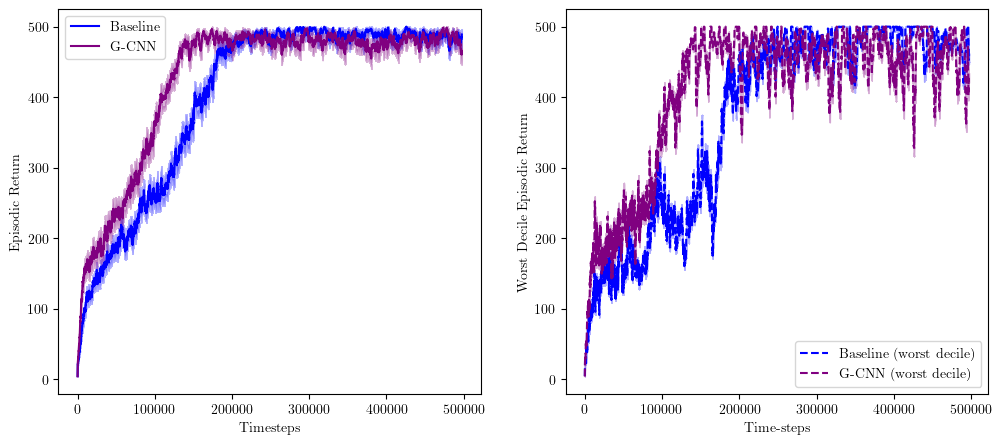

In [ ]:
names= [ "Baseline", "Symmetrizer", "G-CNN"]

def moving_average(x, w=100):
    return np.convolve(x, np.ones(w), "valid") / w


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
colors = ["blue", "black", "purple", "red", "green"]
for c, init_fn, name  in zip(
    colors,
    [
        ActorCritic,
        SymmetrizerNet,
        EquivariantActorCritic,
    ],
    names
):
    if name == "Symmetrizer":
        continue
    else:
        model = init_fn(4)
        if init_fn in [SymmetrizerNet]:
            params = model.init(jax.random.PRNGKey(0), jnp.zeros((1, 4)))
        else:
            params = model.init(jax.random.PRNGKey(0), jnp.zeros((4)))
        print("Name:", init_fn.__name__)
        # print("Param Count:", jax.tree_util.tree_map(lambda x: x.shape, params))
        print("Param Size:", sum(x.size for x in jax.tree_util.tree_leaves(params)))
        episodic_returns = np.load(f"{init_fn.__name__}.npy")
        print(episodic_returns.shape)
        returns_std = moving_average(episodic_returns.std(axis=0)) / np.sqrt(num_seeds)
        returns_mean = moving_average(episodic_returns.mean(axis=0))
        returns_upper = returns_mean + returns_std
        returns_lower = returns_mean - returns_std
        x = np.arange(len(returns_mean))
        
        print(name)
        print(episodic_returns.mean(axis=0)[10_000],"+-", episodic_returns.std(axis=0)[10_000]/np.sqrt(num_seeds))
        print(episodic_returns.mean(axis=0)[100_000],"+-", episodic_returns.std(axis=0)[100_000]/np.sqrt(num_seeds))
        print(episodic_returns.mean(axis=0)[-1],"+-", episodic_returns.std(axis=0)[-1]/np.sqrt(num_seeds))

        ax[0].plot(x, returns_mean, label=f"{name}", color=c)
        ax[0].fill_between(x, returns_lower, returns_upper, alpha=0.3, color=c)
        ax[0].set_xlabel("Timesteps")
        ax[0].set_ylabel("Episodic Return")

        cumulative_returns = np.cumsum(episodic_returns, axis=1)[:, -1]
        worst_decile = np.quantile(cumulative_returns, 0.1)
        worst_mean = episodic_returns[cumulative_returns < worst_decile].mean(axis=0)
        worst_std = episodic_returns[cumulative_returns < worst_decile].std(
            axis=0
        ) / np.sqrt(256)
        worst_upper = worst_mean + worst_std
        worst_lower = worst_mean - worst_std
        ax[1].plot(
            x,
            moving_average(worst_mean),
            label=f"{name} (worst decile)",
            linestyle="--",
            color=c,
        )
        ax[1].fill_between(
            x,
            moving_average(worst_lower),
            moving_average(worst_upper),
            alpha=0.3,
            color=c,
        )
        ax[1].set_xlabel("Time-steps")
        ax[1].set_ylabel("Worst Decile Episodic Return")

ax[0].legend()
ax[1].legend()
plt.show()
fig.savefig("../msc_thesis/Figures/cart_pole_returns.png", dpi=300)